In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score


class CNNet(object):
    
    def __init__(self, learning_rate=0.001, input_dim = 28, num_class=10):
        # Make hyperparameters instance variables. 
        self.learning_rate = learning_rate
        self.num_class = num_class
        self.input_dim = input_dim

        self.initializer = tf.keras.initializers.glorot_uniform()
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)

        # Set Random seed for Tensorflow.
        self.random_seed = 42
        tf.set_random_seed(self.random_seed)
        
        
    def network(self, X, activations=False):
        
        with tf.variable_scope('network', initializer=self.initializer):
            
            # Define the layers.
            self.layers = [

                    tf.layers.Conv2D(filters=16, kernel_size=3,
                                             strides=(1, 1), activation='relu',padding='SAME'),

                    tf.layers.Conv2D(filters=32, kernel_size=3,
                                             strides=(2, 2), activation='relu'),
                    tf.keras.layers.Conv2D(filters=64, kernel_size=3,
                                             strides=(2, 2), activation='relu'),
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(self.num_class)
                ]
        
            # Store activations for investigation later.
            activations_list = []

            # Forward pass loop, store intermediate activations.
            out = X
            for layer in self.layers:
                out = layer(out)
                activations_list.append(out)

            if activations:
                return out, activations_list
            else:
                return out, tf.nn.softmax(out)
            
    def model(self, X, y):
        # Get the logits from the network.
        out_logits, _ = self.network(X)
        
        # Calculate Cross Entropy loss.
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=out_logits))
        
        # Perform backprop wrt loss and update network variables.
        # Instead of doing optimizer.minimize(loss), explicitly defining
        # which variables are trained.
        grads = self.optimizer.compute_gradients(loss)

        vars_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 
                                      scope="network")
        grad_list = [(g, v) for g, v in grads if v in vars_list]
        optimize_op = self.optimizer.apply_gradients(grad_list)

        return loss, optimize_op, out_logits
    
    def metrics(self, y, logits, verbose=True):
    
        # Get prediction values and flatten.
        y = np.argmax(y, axis=1).flatten()
        y_ = np.argmax(logits, axis=1).flatten()

        confusion = confusion_matrix(y_true=y, y_pred=y_)
        accuracy = accuracy_score(y_true=y, y_pred=y_)

        if verbose:
            print ("accuracy score: ", accuracy)
            
        return accuracy
    
    def train(self, train_X, train_y, test_X, test_y, batch_size=256, epochs=100):
        
        # Clear deafult graph stack and reset global graph definition.
        tf.reset_default_graph()

        # GPU config.  
        config = tf.ConfigProto()
        config.gpu_options.allow_growth=True

        # Placeholders for tensors.
        X = tf.placeholder(shape=[None, self.input_dim, self.input_dim, 1], dtype=tf.float32)
        y = tf.placeholder(shape=[None, self.num_class], dtype=tf.float32)

        # Get the ops for training the model.
        loss, optimize, out_logits = self.model(X, y)

        self.saver = tf.train.Saver()
        
        # Initialize session.
        with tf.Session(config=config) as sess:
            
            # Initialize the variables in the graph.
            sess.run(tf.global_variables_initializer())
            sess.run(tf.local_variables_initializer())
            
            # Stochastic Gradient Descent loop.
            
            for step in range(epochs):
                # Total number of batch and start index.
                num_train_batches, start = int(train_X.shape[0]/batch_size), 0
                for _ in range(num_train_batches):
          
                    # Indexes for batch selection.
                    end = start + batch_size         
                    limit = end if end < train_X.shape[0] else train_X.shape[0]
                    idx = np.arange(start, limit)

                    # Run optimization op with batch.
                    _, step_loss = sess.run([optimize, loss],{X: train_X[idx], y: train_y[idx]})

                    start = end
                    
                print('='*80+'\nEpoch: {0} Training Loss: {1}'.format(step, step_loss))
                    
                # Get probabilities and report metrics.
                probs = sess.run(tf.nn.softmax(out_logits), {X: test_X, y: test_y})
                acc = self.metrics(test_y, probs)
                self.saver.save(sess, "model.ckpt")
                
            # Get and save representation space for training set.
            probs = sess.run(out_logits, {X: train_X})
            np.save('representations.npy', probs)
            
        return step_loss, acc
    
    
    def predict(self, X_test, logits=False, reps=False):
        tf.reset_default_graph()
        tf.set_random_seed(42)

        X = tf.placeholder(shape=[None, self.input_dim, self.input_dim, 1], dtype=tf.float32)

        # Get the ops for running inference on the model.
        out_logits, out_probs = self.network(X)

        saver = tf.train.Saver()
        # Initialize a new session on the graph.
        with tf.Session() as sess:

            # Load the trained model into the session to run inference.
            saver.restore(sess, "model.ckpt")
            # Get 
            rep_logits, probs = sess.run([out_logits, out_probs], {X: X_test})
            
        preds = np.argmax(probs, axis=1).flatten()
        if logits:
            return preds, probs
        elif reps:
            return preds, rep_logits
        else:
            return preds


########## DATA MNIST ##########

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Normalize the images, between 0-1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)
#(60000, 28, 28, 1)

print(y_train.shape)
(60000,)

print(x_test.shape)
#(10000, 28, 28, 1)

print(y_test.shape)
#(10000,)

num_class = 10

# Convert labels to one hot encoded vectors.
y_train_oh, y_test_oh = tf.keras.utils.to_categorical(y_train, num_classes= num_class, dtype='float32'), tf.keras.utils.to_categorical(y_test, num_classes= num_class, dtype='float32')

print(y_train_oh.shape)
#(60000, 10)
print(y_test_oh.shape)
#(10000, 10)


# Train the model for 15 epochs.
mnist_classifier = CNNet()
mnist_classifier.train(x_train, y_train_oh, x_test, y_test_oh, epochs=15)


# Train the model for 15 epochs.
mnist_classifier = CNNet()
# Select 10 samples of digit two from the training set.
num_images = 10
mnist_twos = x_train[np.where(y_train == 2)][:num_images]

# Check if model classifies twos correctly.
orig_preds, orig_logits = mnist_classifier.predict(mnist_twos, logits = True)
orig_probs = np.max(orig_logits, axis=1).tolist()
print('Accuracy of sample of twos: ', accuracy_score(orig_preds, [2]*num_images))
#Accuracy of sample of twos:  1.0


(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)
(60000, 10)
(10000, 10)
Epoch: 0 Training Loss: 0.3087162971496582
accuracy score:  0.9587
Epoch: 1 Training Loss: 0.24616146087646484
accuracy score:  0.9742
Epoch: 2 Training Loss: 0.1931505799293518
accuracy score:  0.9799
Epoch: 3 Training Loss: 0.14771677553653717
accuracy score:  0.9841
Epoch: 4 Training Loss: 0.11671457439661026
accuracy score:  0.985
Epoch: 5 Training Loss: 0.0960863009095192
accuracy score:  0.9847
Epoch: 6 Training Loss: 0.07838369160890579
accuracy score:  0.9854
Epoch: 7 Training Loss: 0.0572543665766716
accuracy score:  0.9866
Epoch: 8 Training Loss: 0.04086669161915779
accuracy score:  0.9858
Epoch: 9 Training Loss: 0.025199955329298973
accuracy score:  0.9847
Epoch: 10 Training Loss: 0.024105755612254143
accuracy score:  0.9859
Epoch: 11 Training Loss: 0.0299531277269125
accuracy score:  0.987
Epoch: 12 Training Loss: 0.02957446128129959
accuracy score:  0.9864
Epoch: 13 Training Loss: 0.01050555706

#  Jacobian Saliency Map Approach: JSMA (L0, Targeted)

Papernot et al. (https://arxiv.org/abs/1511.07528) proposed the Jacobian-based saliency map approach (JSMA) to search for adversarial examples by only modifying a limited number of input pixels in an image. As a targeted white-box attack, JSMA iteratively perturbs pixels in an input image that have high adversarial saliency scores, by using the following equation:

$$
S(x, t)[i]=\left\{\begin{array}{ll}{0,} & {\text { if } \frac{\partial F_{t}}{\partial x_{i}}(x)<0 \text { or } \sum_{j \neq t} \frac{\partial F_{j}}{\partial x_{i}}(x)>0} \\ {\frac{\partial F_{t}}{\partial x_{i}}(x)\left|\sum_{j \neq t} \frac{\partial F_{j}}{\partial x_{i}}(x)\right|,} & {\text { otherwise }}\end{array}\right.
$$

![](images/JSMA1.png)

The process is repeated until classification into the target class is achieved, or it reaches the maximum number of perturbed pixels.

![](images/JSMA2.png)

The notion of the saliency map was originally conceived for visualizing how deep neural networks make predictions. The saliency map rates each input feature (e.g., each pixel in an image) by its influence upon the network’s class prediction. Jacobian-based Saliency Map Attacks (JSMA) exploit this information by perturbing a small set of input features to cause misclassification. This is in contrast to attacks like the FGSM that modify most, if not all, input features. As such, JSMA attacks tend to find sparse perturbations.

Note that some JSMA implementations uses the output of the second-to-last layer $Z$, the logits, in the calculation of the gradient, while some might be using the output of the softmax $F$.


In [4]:
advs_jsma, perts_jsma = [], []

target=8
eps=0.5
n_class = 10
cmin=0.0
cmax=1.0
epochs = 100

for imgs in mnist_twos:
    tf.reset_default_graph()
    tf.set_random_seed(42)
    
    X_p = tf.placeholder(shape=[28, 28, 1], dtype=tf.float32)
    logits, probs = mnist_classifier.network(tf.reshape(X_p, shape=(-1,28,28,1)))
    
    # Get model prediction for inputs.
    y_ind = tf.argmax(probs[0])
    #<tf.Tensor 'ArgMax:0' shape=() dtype=int64> a numeric
    
    # probs[0]
    # <tf.Tensor 'strided_slice_1:0' shape=(10,) dtype=float32>
    
    for i in range(10):
        if i==0:
            jacobian = tf.gradients(tf.reshape(logits, (-1,))[i], X_p)
        else:
            jacobian = tf.concat([jacobian, tf.gradients(tf.reshape(logits, (-1,))[i], X_p)],axis=0)
            #<tf.Tensor 'concat_8:0' shape=(10, 28, 28, 1) dtype=float32>
        
    grad_input = jacobian[y_ind]
    grad_target = jacobian[target]
    
    #<tf.Tensor 'strided_slice_13:0' shape=(28, 28, 1) dtype=float32>
    
    grad_other = grad_input - grad_target
    
    c1 = tf.logical_or(eps < 0, X_p < cmax)
    c2 = tf.logical_or(eps > 0, X_p > cmin)
    
    # Check saliency map conditions.
    c3 = grad_target >= 0
    c4 = grad_other <= 0
    
    #score = saliency_map(X_p, target, grad_other, eps, cmin, cmax)
    cond = tf.cast(tf.reduce_all([c1, c2, c3, c4], axis=0),dtype=tf.float32)
    score = cond * (grad_target * tf.abs(grad_other))
  
  # Return score for each pixel
    score = tf.reshape(score, shape=[1, 784])
    #<tf.Tensor 'Reshape_11:0' shape=(1, 784) dtype=float32>
    
    idx = tf.argmax(score, axis=1)
    #<tf.Tensor 'ArgMax_1:0' shape=(1,) dtype=int64>
    
    pert_op = tf.one_hot(idx, 784, on_value=eps, off_value=0.0)
    pert_op = tf.reshape(pert_op, shape=tf.shape(X_p))
    #<tf.Tensor 'Reshape_12:0' shape=(28, 28, 1) dtype=float32>
    
    X_adv = tf.clip_by_value(X_p + pert_op, cmin, cmax)
    #<tf.Tensor 'clip_by_value:0' shape=(28, 28, 1) dtype=float32>
    
    digit = imgs.reshape(28,28,1)
    
    with tf.Session().as_default() as sess:
        tf.train.Saver().restore(sess, "model.ckpt")
        for i in range(epochs):
            digit = sess.run(X_adv, {X_p: digit})
    
    pert = digit - imgs
    
    advs_jsma.append(digit.reshape(28,28))
    perts_jsma.append(pert.reshape(28,28))
    
# Get predictions and confidence for adversarial inputs
preds_jsma, probs_jsma = mnist_classifier.predict(np.array(advs_jsma).reshape(num_images,28,28,1), logits=True)

# Convert predictions and probabilities into lists.
preds_jsma = preds_jsma.tolist()
probs_jsma = np.max(probs_jsma, axis=1).tolist()

In [5]:

def plot_adversarials(origs, perturbs, advs , orig_preds, orig_probs, adv_probs, adv_preds, eps):
    
    fig, axes = plt.subplots(ncols=3, nrows=num_images, figsize=(18,18))

    for i in range(num_images):
        confidence = str(round(orig_probs[i],2))
        pixels = origs[i].reshape((28, 28))
        axes[i][0].imshow(pixels, cmap='gray')
        axes[i][0].set_axis_off()
        title = 'Original\n Predicted: {0} Confidence: {1}' if i==0 else 'Predicted: {0} Confidence: {1}'
        axes[i][0].set_title(title.format(orig_preds[i], confidence))

        pixels = perturbs[i].reshape((28, 28))
        axes[i][1].imshow(pixels, cmap='gray')
        axes[i][1].set_axis_off()
        title = 'Perturbations\n Epsilon: {}' if i==0 else 'Epsilon: {}'
        axes[i][1].set_title(title.format(eps))

        confidence = str(round(adv_probs[i],2))
        pixels = advs[i].reshape((28, 28))
        axes[i][2].imshow(pixels, cmap='gray')
        axes[i][2].set_axis_off()
        title = 'Adversarial\n Predicted: {0} Confidence: {1}' if i==0 else 'Predicted: {0} Confidence: {1}'
        axes[i][2].set_title(title.format(adv_preds[i], confidence))

    plt.show()

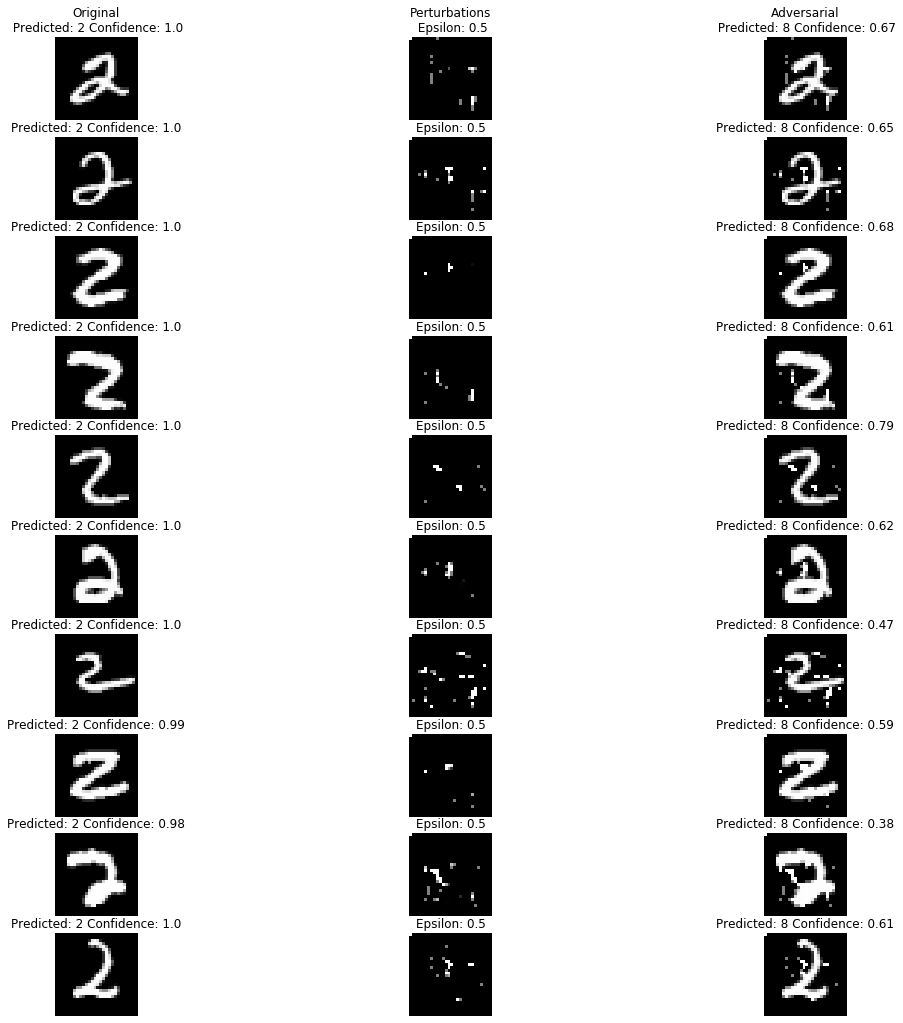

In [6]:
plot_adversarials(mnist_twos, np.array(perts_jsma), np.array(advs_jsma),orig_preds, orig_probs, probs_jsma, preds_jsma, eps=0.5)